In [3]:
import random
import torch
import numpy as np

In [4]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distrubtion()
        self.update_state()
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def get_state(self):
        return self.state 
        
    def init_distrubtion(self):
        self.bandit_matrix = np.random.rand(self.arms, self.arms)
        
    def update_state(self):
        self.state = np.random.randint(0, self.arms)

    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [5]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [6]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU()
)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

env = ContextBandit()

In [7]:
def softmax(av, tau):
    softmax = np.exp(av/tau) / np.sum(np.exp(av/tau))
    return softmax

In [19]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state)
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        av_softmax /= av_softmax.sum()
        choice = np.random.choice(arms, p=av_softmax)
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.detach().numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    return np.array(rewards)

In [20]:
test1 = train(env)

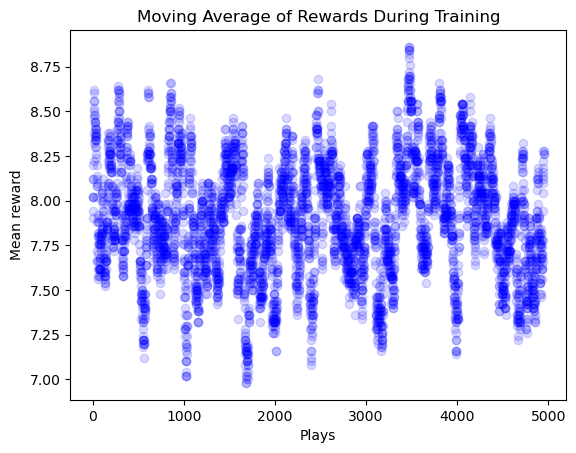

In [38]:
import matplotlib.pyplot as plt
import numpy as np

window_size = 50  # You can adjust this window size as needed

# Calculate the moving average
moving_avg = np.convolve(test1, np.ones(window_size)/window_size, mode='valid')

x = np.arange(len(moving_avg))

plt.scatter(x, moving_avg, label='Moving Average', color='blue', alpha = 0.15)
plt.xlabel('Plays')
plt.ylabel('Mean reward')
plt.title('Moving Average of Rewards During Training')

plt.show()